In [31]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.dates as mdates

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# importar datos
ruta = '/content/drive/MyDrive/A_A1.csv'
data = pd.read_csv(ruta)

In [4]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data['day_of_week'] = data['datetime'].dt.dayofweek

In [6]:
# dividir dataset para dirigir al entrenamiento y para el test
train_df = data[data['year'] < 2020].copy()
test_df = data[data['year'] == 2020].copy()

In [7]:
# presentacion de los datos para entrenar y para el test
print("Datos para el entrenamiento:")
print(train_df.head().to_markdown(index=False, numalign="left", stralign="left"))

print("\nDatos para el test:")
print(test_df.head().to_markdown(index=False, numalign="left", stralign="left"))

Datos para el entrenamiento:
| datetime            | substation   | feeder   | consumption   | year   | month   | day   | hour   | day_of_week   |
|:--------------------|:-------------|:---------|:--------------|:-------|:--------|:------|:-------|:--------------|
| 2017-01-01 00:00:00 | A            | A1       | 64.6714       | 2017   | 1       | 1     | 0      | 6             |
| 2017-01-01 01:00:00 | A            | A1       | 58            | 2017   | 1       | 1     | 1      | 6             |
| 2017-01-01 02:00:00 | A            | A1       | 58            | 2017   | 1       | 1     | 2      | 6             |
| 2017-01-01 03:00:00 | A            | A1       | 58            | 2017   | 1       | 1     | 3      | 6             |
| 2017-01-01 04:00:00 | A            | A1       | 52            | 2017   | 1       | 1     | 4      | 6             |

Datos para el test:
| datetime            | substation   | feeder   | consumption   | year   | month   | day   | hour   | day_of_week   |
|:----

In [8]:
# eliminacion de datos NAN
train_data_clean = train_df.dropna(subset=['consumption'])
test_data_clean = test_df.dropna(subset=['consumption'])

In [9]:
# verificar que no queden datos NAN
valores_nulos_consumption = train_data_clean['consumption'].isnull().sum()
valores_nulos_consumption

0

In [10]:
# definir funcion de lo que se quiere predecir y sus variables
def prepare_data(df):
    features = ['year', 'month', 'day', 'hour', 'day_of_week']
    X = df[features]
    y = df['consumption']
    return X, y

In [11]:
#
X_train_clean, y_train_clean = prepare_data(train_data_clean)
X_test_clean, y_test_clean = prepare_data(test_data_clean)

In [12]:
# modelo de regresion lineal
lr_model = LinearRegression()
# Entrenamiento del modelo
lr_model.fit(X_train_clean, y_train_clean)
# Realizar predicciones
y_pred_lr = lr_model.predict(X_test_clean)
# Metricas de desempenho
mae_lr = mean_absolute_error(y_test_clean, y_pred_lr)
mse_lr = mean_squared_error(y_test_clean, y_pred_lr)
rmse_lr = mse_lr ** 0.5

In [13]:
print(f'Regresión Lineal - MAE: {mae_lr}, MSE: {mse_lr}, RMSE: {rmse_lr}')

Regresión Lineal - MAE: 13.728833361728672, MSE: 322.6680437521699, RMSE: 17.96296311169652


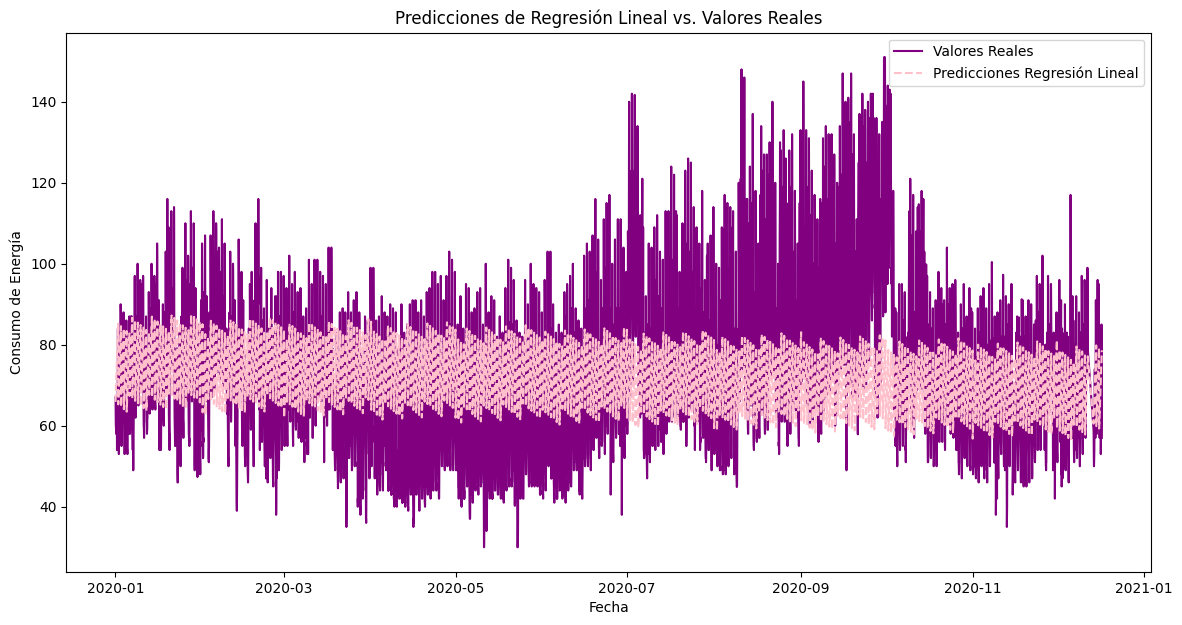

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(test_data_clean['datetime'], y_test_clean, label='Valores Reales', color='purple')
plt.plot(test_data_clean['datetime'], y_pred_lr, label='Predicciones Regresión Lineal', color='pink', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title('Predicciones de Regresión Lineal vs. Valores Reales')
plt.legend()
plt.show()

In [15]:
# la prediccion no funciona como esperamos con la regresion lineal, procedemos a probar otro metodo

In [16]:
# escalar datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data_clean[['consumption']])
test_scaled = scaler.transform(test_data_clean[['consumption']])

In [17]:
# preparacion de datos para LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# reshape de entrada para [samples, time steps, features]
time_step = 24
X_train_lstm, y_train_lstm = create_dataset(train_scaled, time_step)
X_test_lstm, y_test_lstm = create_dataset(test_scaled, time_step)

In [19]:
# crear el modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model_lstm.add(LSTM(50, return_sequences=True))  # Agrega una segunda capa LSTM
model_lstm.add(Dropout(0.2))  # Agrega Dropout después de la segunda capa LSTM
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
# entrenar el modelo
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=30, batch_size=64, validation_data=(X_test_lstm, y_test_lstm), verbose=1)

Epoch 1/30
405/405 [==============================] - 31s 59ms/step - loss: 0.0132 - val_loss: 0.0088
Epoch 2/30
405/405 [==============================] - 23s 56ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 3/30
405/405 [==============================] - 21s 52ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 4/30
405/405 [==============================] - 23s 56ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/30
405/405 [==============================] - 20s 51ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/30
405/405 [==============================] - 22s 55ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/30
405/405 [==============================] - 21s 51ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 8/30
405/405 [==============================] - 22s 54ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 9/30
405/405 [==============================] - 21s 53ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 10/30
405/405 [==============================] - 21s 52ms/step - loss: 0.002

In [21]:
# realizar predicciones
train_predict = model_lstm.predict(X_train_lstm)
test_predict = model_lstm.predict(X_test_lstm)

261/261 [==============================] - 3s 12ms/step


In [22]:
# invertir la escala de las predicciones
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [23]:
# calcular metricas de desempeño
y_train_lstm_aligned = y_train_clean[time_step:time_step + len(train_predict)]
y_test_lstm_aligned = y_test_clean[time_step:time_step + len(test_predict)]

In [24]:
# graficar los resultados de entrenamiento y prueba
plt.figure(figsize=(14, 7))

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

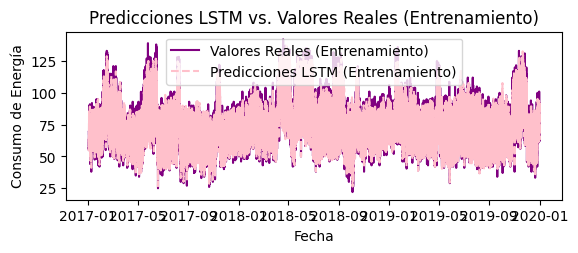

In [25]:
# graficar datos de entrenamiento
plt.subplot(2, 1, 1)
plt.plot(train_data_clean['datetime'][time_step:time_step + len(train_predict)], y_train_lstm_aligned, label='Valores Reales (Entrenamiento)', color='purple')
plt.plot(train_data_clean['datetime'][time_step:time_step + len(train_predict)], train_predict, label='Predicciones LSTM (Entrenamiento)', color='pink', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title('Predicciones LSTM vs. Valores Reales (Entrenamiento)')
plt.legend()

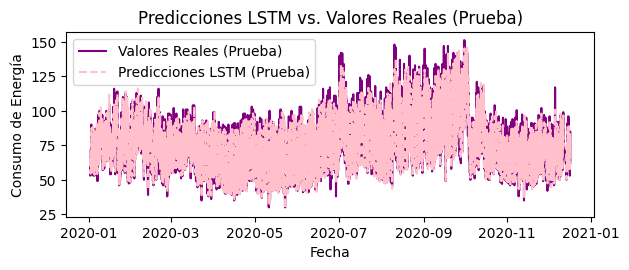

In [26]:
# graficar datos de prueba
plt.subplot(2, 1, 2)
plt.plot(test_data_clean['datetime'][time_step:time_step + len(test_predict)], y_test_lstm_aligned, label='Valores Reales (Prueba)', color='purple')
plt.plot(test_data_clean['datetime'][time_step:time_step + len(test_predict)], test_predict, label='Predicciones LSTM (Prueba)', color='pink', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energía')
plt.title('Predicciones LSTM vs. Valores Reales (Prueba)')
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
# Calcular R2
r2_train_lstm = r2_score(y_train_lstm_aligned, train_predict)
r2_test_lstm = r2_score(y_test_lstm_aligned, test_predict)

# Calcular MAE
mae_train_lstm = mean_absolute_error(y_train_lstm_aligned, train_predict)
mae_test_lstm = mean_absolute_error(y_test_lstm_aligned, test_predict)

# Calcular MSE
mse_train_lstm = mean_squared_error(y_train_lstm_aligned, train_predict)
mse_test_lstm = mean_squared_error(y_test_lstm_aligned, test_predict)

print(f'LSTM - R^2 Entrenamiento: {r2_train_lstm}')
print(f'LSTM - R^2 Prueba: {r2_test_lstm}')
print(f'LSTM - MAE Entrenamiento: {mae_train_lstm}')
print(f'LSTM - MAE Prueba: {mae_test_lstm}')
print(f'LSTM - MSE Entrenamiento: {mse_train_lstm}')
print(f'LSTM - MSE Prueba: {mse_test_lstm}')

LSTM - R^2 Entrenamiento: 0.9125644097701169
LSTM - R^2 Prueba: 0.9287278449605322
LSTM - MAE Entrenamiento: 3.390256475071444
LSTM - MAE Prueba: 3.448005956586632
LSTM - MSE Entrenamiento: 24.97304688454796
LSTM - MSE Prueba: 25.210537717670604


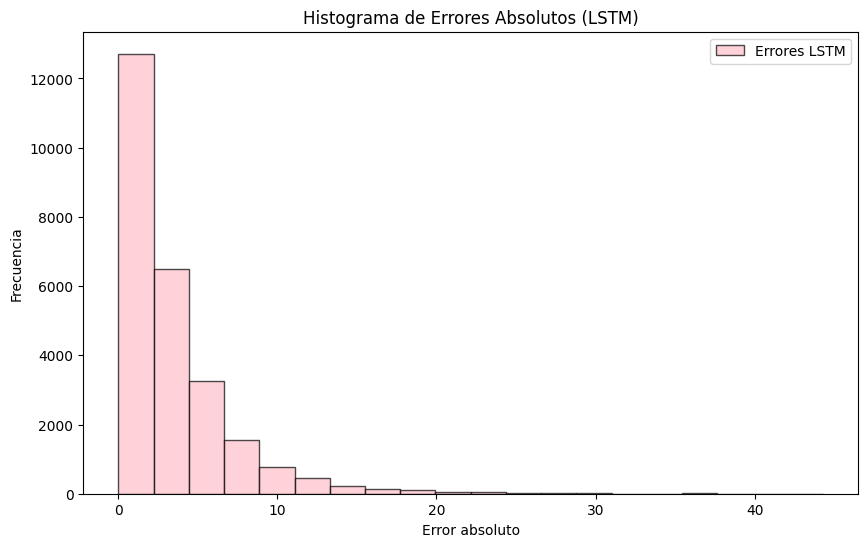

In [28]:
# Calcular los errores absolutos
y_train_lstm_aligned = y_train_clean[time_step:time_step + len(train_predict)]
train_errors_lstm = np.abs(y_train_lstm_aligned - train_predict.flatten())

# Crear histograma de los errores
plt.figure(figsize=(10, 6))
plt.hist(train_errors_lstm, bins=20, edgecolor='black', color='pink', alpha=0.7, label='Errores LSTM')
plt.xlabel('Error absoluto')
plt.ylabel('Frecuencia')
plt.title('Histograma de Errores Absolutos (LSTM)')
plt.legend()
plt.show()

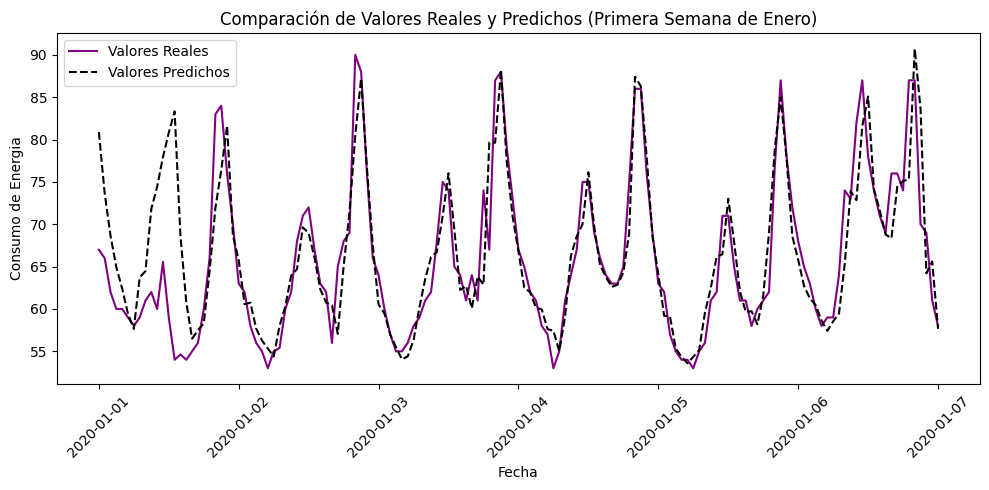

In [35]:
# Seleccionar la primera semana de enero del conjunto de prueba
start_date = '2020-01-01'
end_date = '2020-01-07'
week_data = test_data_clean[(test_data_clean['datetime'] >= start_date) & (test_data_clean['datetime'] <= end_date)]

# Ajustar los índices de las predicciones para que coincidan con los datos originales
week_indices = (test_data_clean['datetime'] >= start_date) & (test_data_clean['datetime'] <= end_date)
aligned_indices = np.where(week_indices)[0] - time_step

# Filtrar los valores reales y predichos correspondientes a la semana
week_real_values = y_test_clean[week_indices]
week_predicted_values = test_predict[aligned_indices]

# Graficar los valores reales y predichos para la semana seleccionada
plt.figure(figsize=(10, 5))
plt.plot(week_data['datetime'], week_real_values, label='Valores Reales', color='purple')
plt.plot(week_data['datetime'], week_predicted_values, label='Valores Predichos', color='black', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Consumo de Energia')
plt.title('Comparación de Valores Reales y Predichos (Primera Semana de Enero)')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()